# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

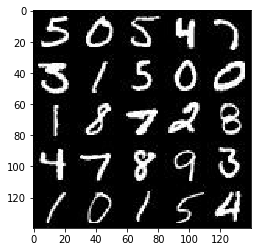

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

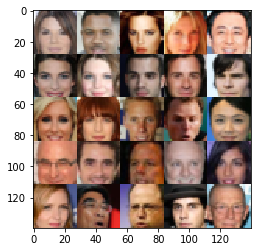

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim=(image_width,image_height,image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=1.0)) 
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        #x4 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 7x7x128 now

        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * x4, x4)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
    
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 2.6344... Generator Loss: 0.2434
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.2720
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.7310


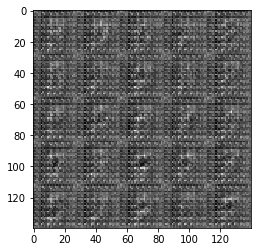

Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 2.2983
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 2.0232
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.2950
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.4539
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 1.7794


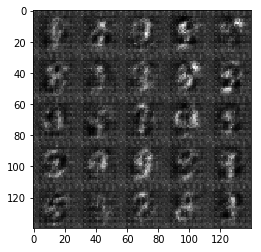

Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.3571
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 2.0879
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.5631
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 0.9645


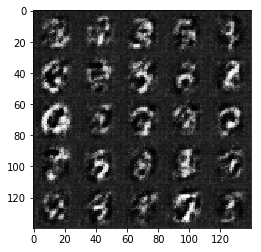

Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 1.4985
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 2.1110
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 1.4472


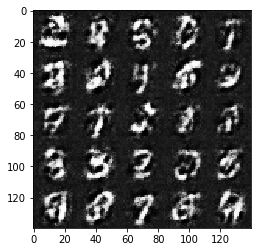

Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.5249
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.1222
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.3733
Epoch 1/2... Discriminator Loss: 1.7506... Generator Loss: 0.2210


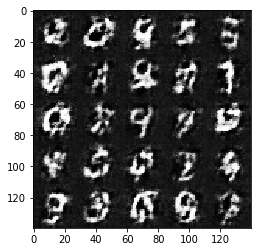

Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.2211
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 2.2272
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 2.4060
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 0.9074


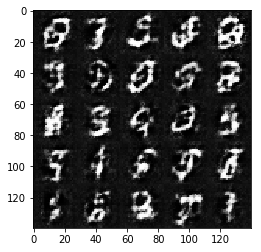

Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.2238
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.4023
Epoch 1/2... Discriminator Loss: 2.4359... Generator Loss: 0.1382
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.4515
Epoch 1/2... Discriminator Loss: 2.1251... Generator Loss: 0.1846
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 2.1770
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 0.8383


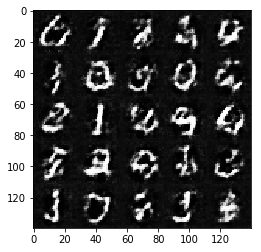

Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.5028
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.2827
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 2.1840
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 2.3928
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.2748


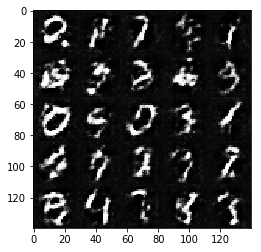

Epoch 1/2... Discriminator Loss: 1.8533... Generator Loss: 0.2213
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.3553
Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 0.2604
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 1.2277
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.7992


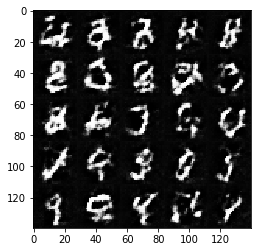

Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.5465
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.2845
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 0.9366


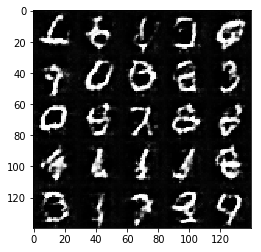

Epoch 1/2... Discriminator Loss: 1.8053... Generator Loss: 0.2223
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 2.4221
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.9480... Generator Loss: 0.2000
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.3760
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.9773


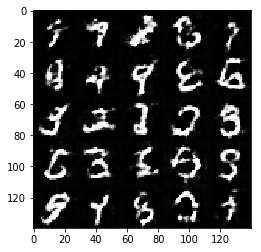

Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.3601
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 0.7939... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 1.9313... Generator Loss: 0.2171
Epoch 1/2... Discriminator Loss: 2.5592... Generator Loss: 0.1106
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.2583
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.4384


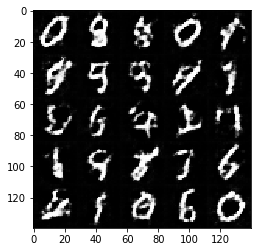

Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 1.9054
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 3.0826
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 0.7707


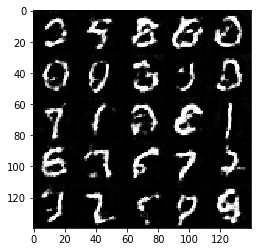

Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 2.1332... Generator Loss: 0.1556
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.3994
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.4728
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.6217


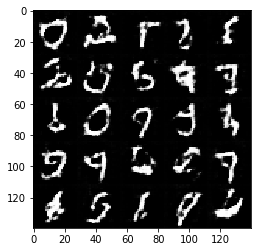

Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.3016
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 1.9533
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.4073


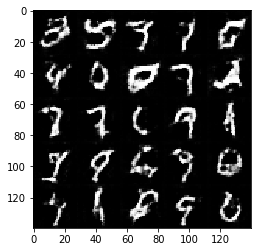

Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.3398
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.3373
Epoch 1/2... Discriminator Loss: 1.7282... Generator Loss: 0.2321
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 2.5620


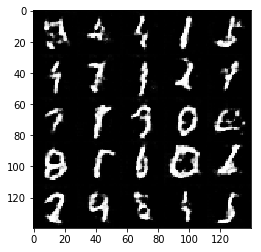

Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.3225
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.3945
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.3973
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.6378


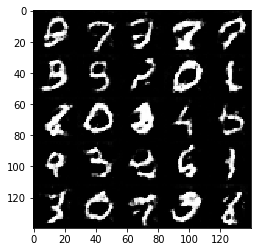

Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 5.1212... Generator Loss: 6.1841
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.3976
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 0.7781


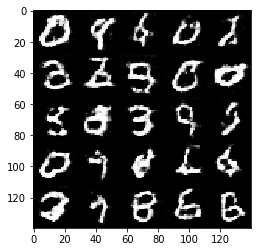

Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.8303
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.3403
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 0.7443
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 1.6373
Epoch 2/2... Discriminator Loss: 1.6180... Generator Loss: 0.2701
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.5463


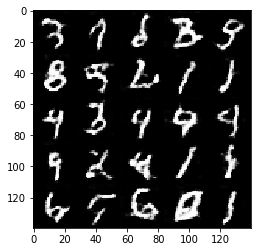

Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.4869
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.1548
Epoch 2/2... Discriminator Loss: 1.9956... Generator Loss: 0.2360
Epoch 2/2... Discriminator Loss: 3.6940... Generator Loss: 0.0551
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 2.3006
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.2202


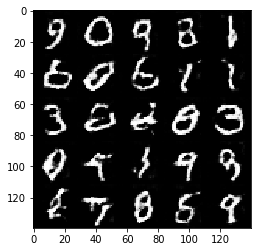

Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.1960
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 1.6313
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 1.1890


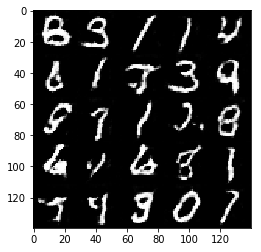

Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.1056
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 1.3429
Epoch 2/2... Discriminator Loss: 1.6335... Generator Loss: 0.2853
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.4975
Epoch 2/2... Discriminator Loss: 1.7320... Generator Loss: 0.2697
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.6225


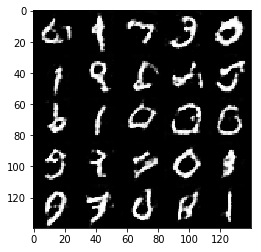

Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 3.0178... Generator Loss: 0.0720
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.4155
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.5243
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.9996... Generator Loss: 0.1750


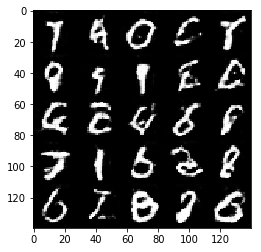

Epoch 2/2... Discriminator Loss: 1.6216... Generator Loss: 0.2919
Epoch 2/2... Discriminator Loss: 2.0036... Generator Loss: 0.1823
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 1.6179... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.3074
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 0.5598
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 0.6222
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 2.4248


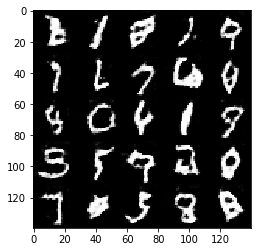

Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 1.9886
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9196
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 1.8598... Generator Loss: 0.2745
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.0473


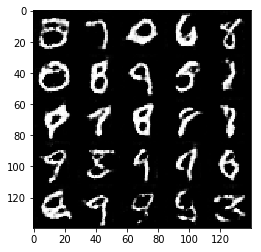

Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.7786
Epoch 2/2... Discriminator Loss: 0.4889... Generator Loss: 2.0605
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.6913... Generator Loss: 0.2891
Epoch 2/2... Discriminator Loss: 0.7387... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 3.0566... Generator Loss: 5.4613
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 2.4938
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 0.8370


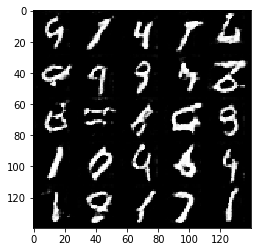

Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 1.6437... Generator Loss: 0.3269
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.4257
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.3225
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.5969
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.3638


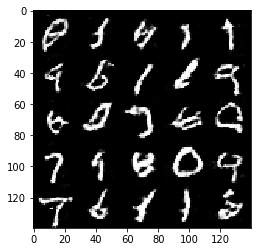

Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 1.1623
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 2.3631
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.6026
Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.7286


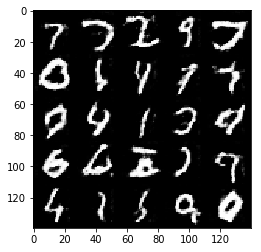

Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.5512
Epoch 2/2... Discriminator Loss: 2.5018... Generator Loss: 0.1099
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.6765
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.7308... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.1324


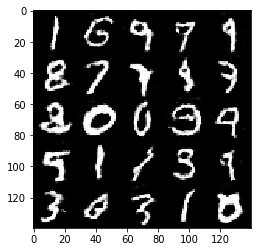

Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 1.6083... Generator Loss: 0.3101
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.1573
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.1452


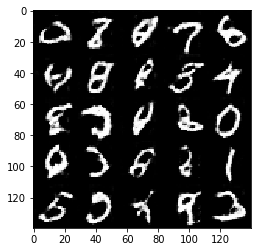

Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.1979
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.6757
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.3841
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.8842


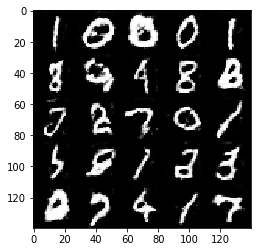

Epoch 2/2... Discriminator Loss: 1.5225... Generator Loss: 0.4391
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 2.0047
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.5239... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 2.7703... Generator Loss: 0.1080
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 0.7348
Epoch 2/2... Discriminator Loss: 4.2230... Generator Loss: 0.0254


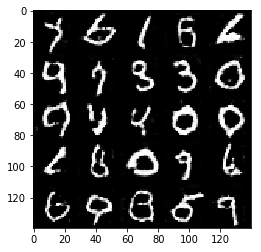

Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.7599
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.5631
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.0172


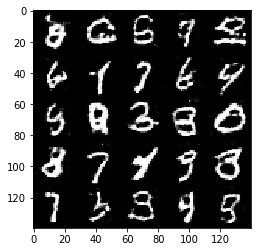

Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.6607
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.7525
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 2.0855
Epoch 2/2... Discriminator Loss: 1.5681... Generator Loss: 0.3227
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.7450


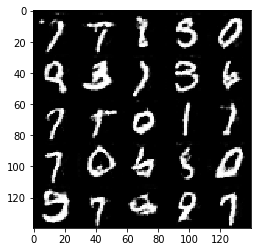

Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.3917
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 3.5534
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.1763
Epoch 2/2... Discriminator Loss: 1.6431... Generator Loss: 0.2775
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 2.3494


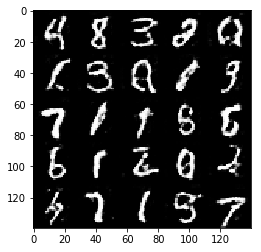

Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.6241... Generator Loss: 0.2755
Epoch 2/2... Discriminator Loss: 1.5476... Generator Loss: 0.3622
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.6500


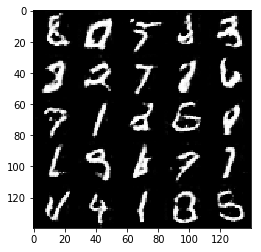

Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 2.2309... Generator Loss: 0.1861
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.4223
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.5357
Epoch 2/2... Discriminator Loss: 2.1389... Generator Loss: 0.2140


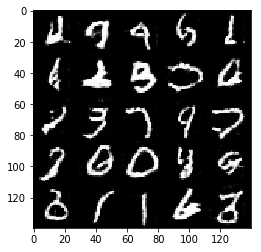

Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 0.6483... Generator Loss: 0.9641


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1652... Generator Loss: 0.0672
Epoch 1/1... Discriminator Loss: 1.8755... Generator Loss: 0.2420
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.7659... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 2.7289... Generator Loss: 0.0809
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 5.4491
Epoch 1/1... Discriminator Loss: 0.3110... Generator Loss: 3.5125
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.0913


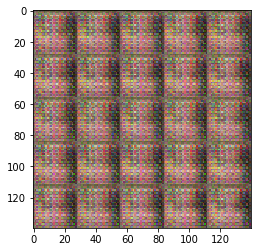

Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 2.6476
Epoch 1/1... Discriminator Loss: 0.2507... Generator Loss: 2.1043
Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.2135... Generator Loss: 3.7419
Epoch 1/1... Discriminator Loss: 0.1712... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.6919


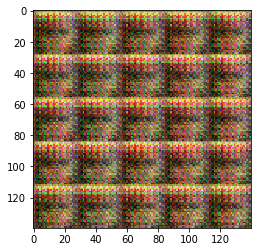

Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 2.1628
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 2.0130
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 2.6238
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 7.3271
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 2.4937
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 4.2646
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.5845


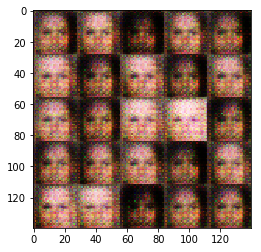

Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 2.5431
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.2735
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.8705
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.8651... Generator Loss: 0.2228


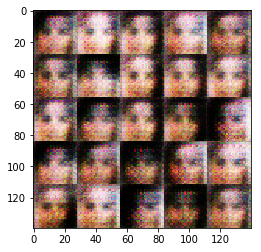

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 3.1102
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 2.2903
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 2.2509
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 3.1309
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 0.3180


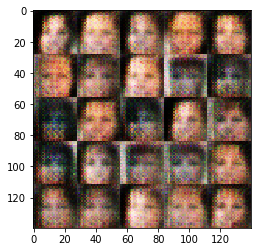

Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 1.5509


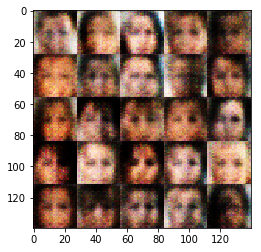

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 2.0261... Generator Loss: 0.2169
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 1.0077


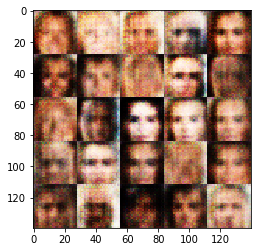

Epoch 1/1... Discriminator Loss: 1.7077... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8293


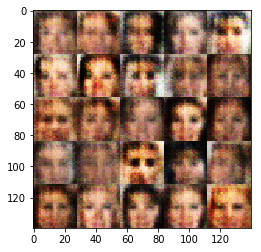

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.0305


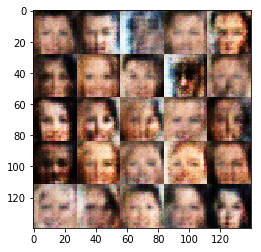

Epoch 1/1... Discriminator Loss: 1.8577... Generator Loss: 0.2227
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7154


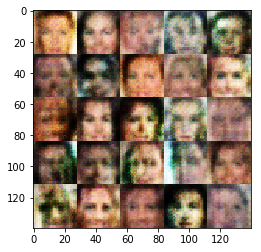

Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.1359


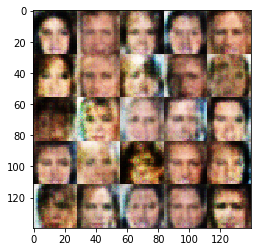

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.5997


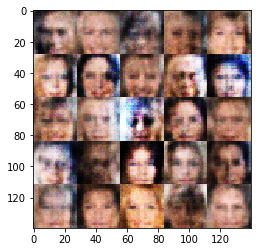

Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.5268


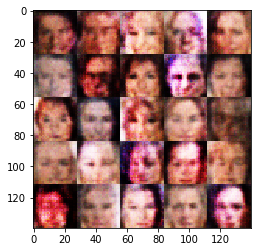

Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.3004
Epoch 1/1... Discriminator Loss: 1.7523... Generator Loss: 0.2637
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.4233


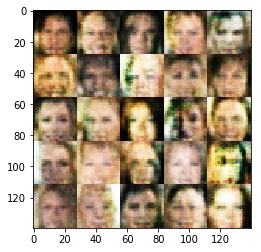

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6957


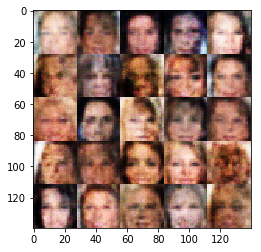

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5692


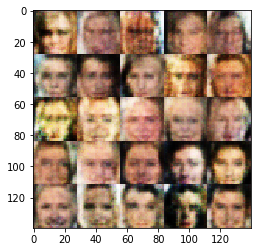

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.4480


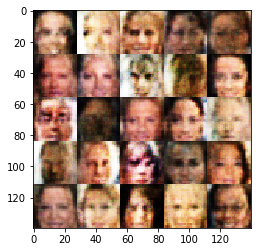

Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.5022


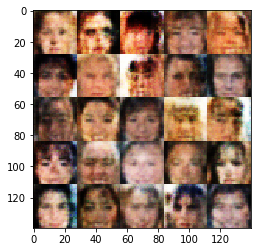

Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.3355


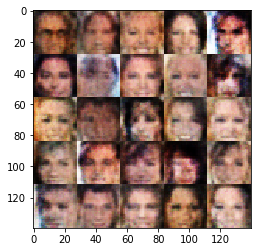

Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.4850


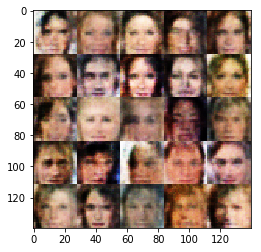

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6198


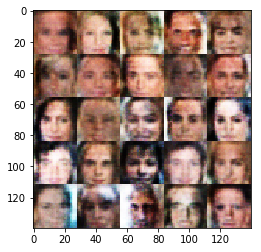

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6170


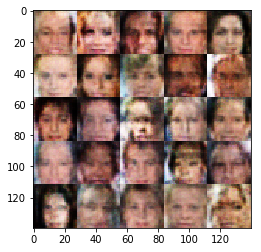

Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5719


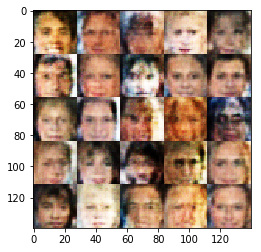

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.8327


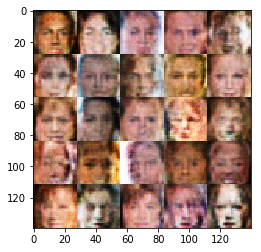

Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4927


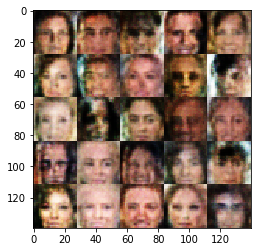

Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.3379


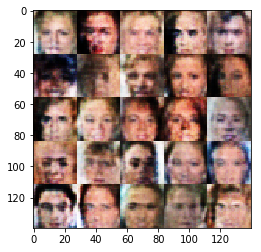

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.3116


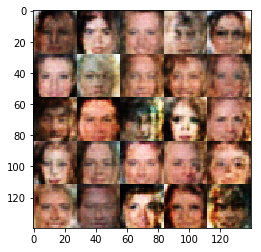

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.4655


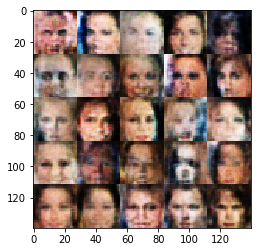

Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.6924... Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6039


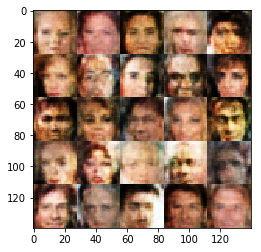

Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.6477


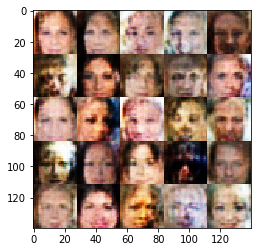

Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5336


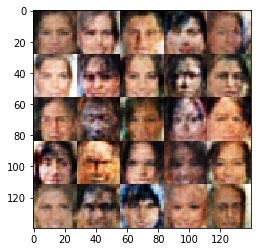

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.7708... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6425


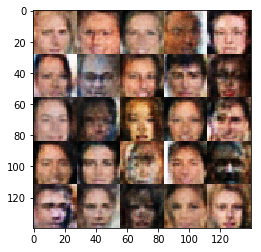

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.3665


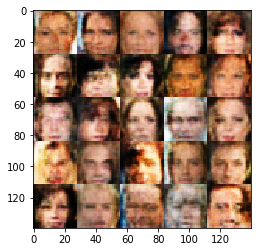

Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5509


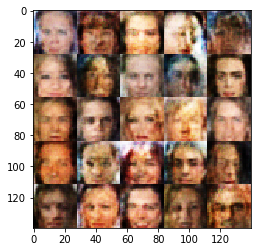

Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.8787... Generator Loss: 0.3450
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.4270


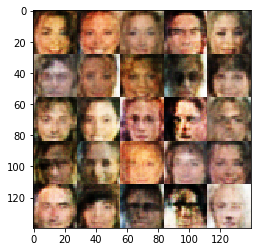

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5651


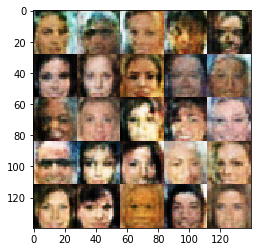

Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7886


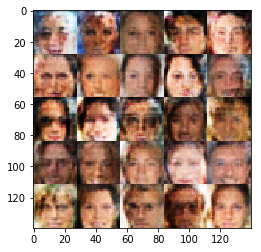

Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5670


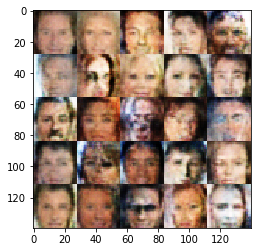

Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.8233... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4575


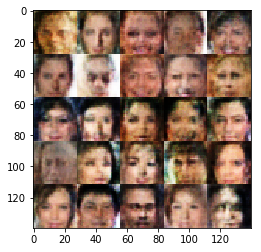

Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.5145


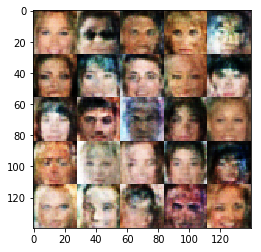

Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7032


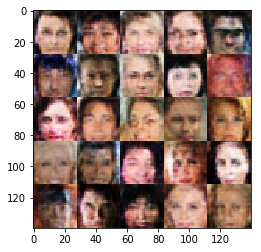

Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4306


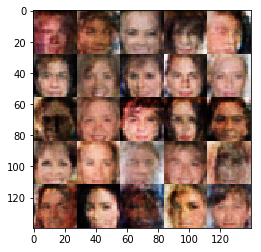

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.4004


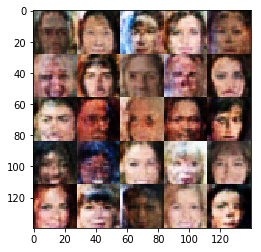

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7260


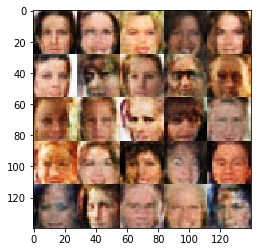

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6293


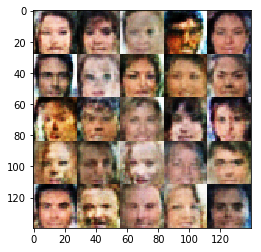

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5608


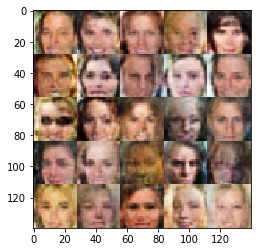

Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5103


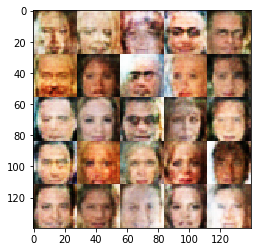

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.3189
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.6824... Generator Loss: 0.5140


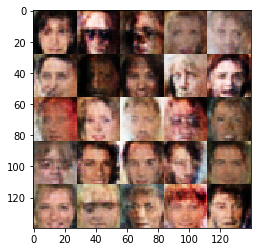

Epoch 1/1... Discriminator Loss: 1.8310... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.5298


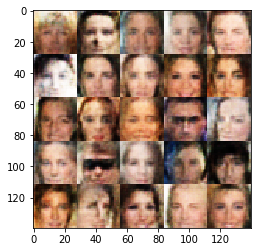

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5478


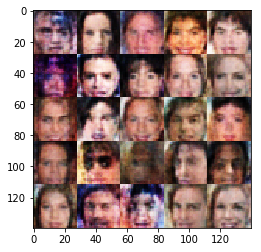

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5637


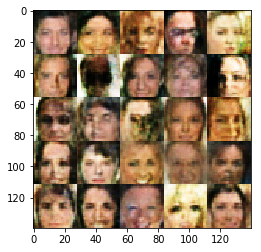

Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7211


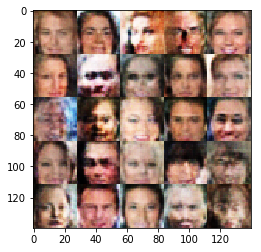

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6936


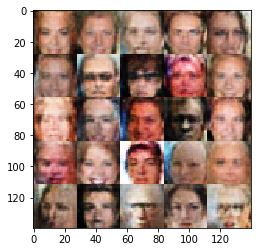

Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6202


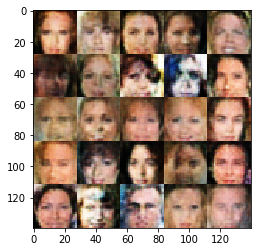

Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.6531


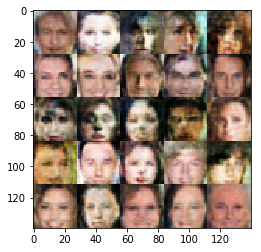

Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5628


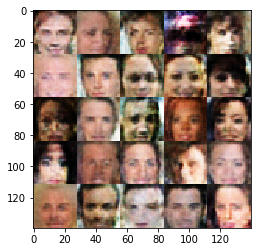

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5086


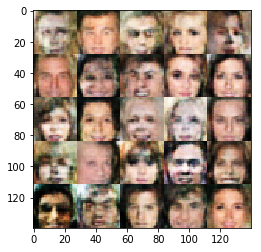

Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.7025... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5618


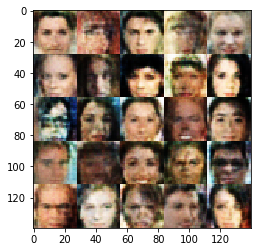

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.5751


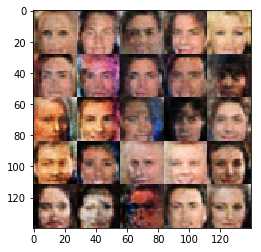

Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.0187


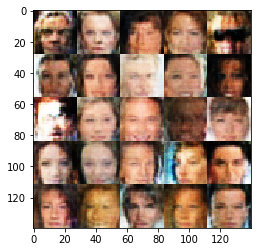

Epoch 1/1... Discriminator Loss: 1.7241... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6583


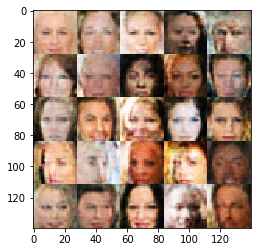

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.5716


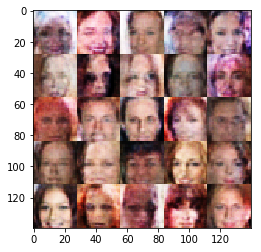

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4299


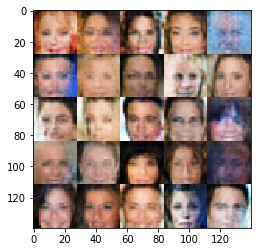

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.4716


In [11]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.